# Deep learning model compression for agricultural devices

In [75]:
import tensorflow as tf
import tempfile
import zipfile
from __future__ import division, print_function, absolute_import
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D

from keras.optimizers import SGD
import numpy as np
import cv2
import os

In [76]:
from keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# DATA

## This code load dataset from googleDrinve

In [77]:
import zipfile, os
zip_ref = zipfile.ZipFile('/content/train.zip', 'r')
zip_ref.extractall('Data')
zip_ref.close()

return the content of the dataset

Traning images and labels, test images and labes, and and the number of class

In [78]:
def load_dataset(rootDir):
    root=rootDir
    folders = os.listdir(root)
    nb = len(folders)
    x_data=[]
    y_label=[]
    xt_data=[]
    yt_label=[]
    for x in range(nb):
        label=np.zeros(nb)
        label[x]=1
        PlantPath=os.listdir(root+"/"+folders[x])
        plants=[root+"/"+folders[x]+"/"+f for f in PlantPath if (f.endswith(".png") or f.endswith(".jpg") or f.endswith(".JPG"))]
        i=0
        for plant in plants:
            imgs=cv2.imread(plant)
            imgs= cv2.resize(imgs,(50,50))
            if(i%5==0):
                xt_data.extend([imgs])
                yt_label.extend([label])
            else:
                x_data.extend([imgs])
                y_label.extend([label])
            i=i+1
    return (np.asarray(x_data), np.asarray(y_label), np.asarray(xt_data), np.asarray(yt_label), nb)


# Pruning CallBack

In [79]:
class PruningCallback(tf.keras.callbacks.Callback):
	def __init__(self, init_step, end_step, init_sparsity, end_sparsity, pruning_step):
		self.init_step=init_step; self.end_step=end_step
		self.init_sparsity=init_sparsity; self.end_sparsity=end_sparsity
		self.pruning_step=pruning_step
		self.W_mask=[]
		super().__init__()
	def on_train_begin(self, logs=None):
		for layer in self.model.layers:
			if("filters" in layer.get_config()):
				self.W_mask.append(np.ones(layer.get_weights()[0].shape))
		
	def decayed_sparsity_level(self,step):
		step = min(step-self.init_step, self.end_step)
		return ((self.init_sparsity-self.end_sparsity) *
          (1 - step / (self.end_step-self.init_step)) ** (1)
          ) + self.end_sparsity

	def on_epoch_end(self, epoch, logs={}):
		if((epoch)%self.pruning_step==0 and (epoch)>=self.init_step and (epoch)<=self.end_step):
			print('\n pruning [', end=' ')
		i=0
		layers=self.model.layers
		for l in range(len(layers)):
			if("filters" in layers[l].get_config()):
				w_m=tf.convert_to_tensor(self.W_mask[i], dtype=tf.float32)
				w_l=tf.convert_to_tensor(self.model.layers[l].get_weights()[0], dtype=tf.float32)
				w_l2=tf.multiply(w_m,w_l).numpy()
				b=self.model.layers[l].get_weights()[1]
				self.model.layers[l].set_weights([w_l2,b])
				#Pruninf
				print('=', end=' ')
				if((epoch)%self.pruning_step==0  and (epoch)>=self.init_step and (epoch)<=self.end_step):
					filters_sum=np.abs(tf.reduce_sum(w_l2, [0, 1, 2]).numpy())
					Ws=tf.sort(filters_sum,  axis=-1, direction='ASCENDING', name=None).numpy()
					step_sparsty=self.decayed_sparsity_level(epoch)
					threshold=Ws[int(len(Ws)*step_sparsty)]
					e=np.where(filters_sum <= threshold)
					e=np.array(e).reshape(-1)
					for ex in e:
						if(len(self.W_mask[i].shape)==4):
							self.W_mask[i][:,:,:,ex]=0
							b[ex]=0
				#setting weights
				w_m=tf.convert_to_tensor(self.W_mask[i], dtype=tf.float32)
				w_l2=tf.multiply(w_m,w_l).numpy()
				i=i+1
				self.model.layers[l].set_weights([w_l2,b])
				
			if  isinstance(layers[l], tf.keras.layers.Dense):
				w_l=layers[l].get_weights()[0]
				bias=layers[l].get_weights()[1]
				s_mask=tf.reduce_sum(self.W_mask[-1], [0, 1, 2]).numpy()
				indx=np.where(s_mask ==0.)
				indx=np.array(indx).reshape(-1)
				li=int(w_l.shape[0]/len(s_mask))
				ind_fc=[]
				for ind in indx:
					x=np.arange(li*ind, li*(ind+1))
					ind_fc.append(x)
				ind_fc=np.array(ind_fc).reshape(-1)
				for ind_fc_ in ind_fc:
					w_l[ind_fc_,:]=0
				self.model.layers[l].set_weights([w_l,bias])
		
			if isinstance(layers[l], tf.keras.layers.BatchNormalization):
				w_l=layers[l].get_weights()
				s_mask=tf.reduce_sum(self.W_mask[i-1], [0, 1, 2]).numpy()
				indx=np.where(s_mask ==0.)
				indx=np.array(indx).reshape(-1)
				for ind in indx:
					w_l[0][ind]=0
					w_l[1][ind]=0
					w_l[2][ind]=0
					w_l[3][ind]=0
				self.model.layers[l].set_weights(w_l)
		
		if((epoch)%self.pruning_step==0 and (epoch)>=self.init_step and (epoch)<=self.end_step):
			print(']')
	
	#Transfert create a new model without pruned filters 
	def get_thinner_model(self):
		original_model=self.model
		W_mask=self.W_mask
		self.preview=[3]
		self.mask_ind=[0]
		compressed_model = tf.keras.models.clone_model(original_model,	clone_function=self.build_compressed_CNN,)
		self.preview_w=[[0,1,2]]
		compressed_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="sgd", metrics=['accuracy'])
		mask_i=0
		for l_index in range( len(original_model.layers)):
			layer=original_model.layers[l_index]
			if isinstance(layer, tf.keras.layers.Conv2D):
				w_l=layer.get_weights()[0]
				bias=layer.get_weights()[1]
				filters_sum=np.abs(tf.reduce_sum(w_l, [0, 1, 2]).numpy())
				indx=np.where(filters_sum !=0.)
				indxz=np.array(np.where(filters_sum ==0.)).reshape(-1)
				indx=np.array(indx).reshape(-1)
				if (l_index!=0):
					w_l=w_l[:,:,self.preview_w[-1],:]
				w_l_r=w_l[:,:,:,indxz]
				w_l=w_l[:,:,:,indx]
				print(w_l.shape)
				print(np.sum(w_l), np.sum(w_l_r))
				self.preview_w.append(indx)
				bias=np.array([bias[i] for i in indx])
				compressed_model.layers[l_index].set_weights([w_l,bias])
				mask_i=mask_i+1
			if isinstance(layer, tf.keras.layers.BatchNormalization):
				w_l=layer.get_weights()
				#print(w_l)
				w_l[0]=np.array([w_l[0][i] for i in self.preview_w[-1]])
				w_l[1]=np.array([w_l[1][i] for i in self.preview_w[-1]])
				w_l[2]=np.array([w_l[2][i] for i in self.preview_w[-1]])
				w_l[3]=np.array([w_l[3][i] for i in self.preview_w[-1]])
				compressed_model.layers[l_index].set_weights(w_l)
			if isinstance(layer, tf.keras.layers.Dense):
				w_l=layer.get_weights()[0]
				bias=layer.get_weights()[1]
				s_mask=tf.reduce_sum(self.W_mask[-1], [0, 1, 2]).numpy()
				indx=np.where(s_mask !=0.)
				indx=np.array(indx).reshape(-1)
				w_l=w_l.reshape(-1,len(s_mask),len(bias))
				w_l=w_l[:,indx,:]
				w_l=w_l.reshape(-1,len(bias))
				compressed_model.layers[l_index].set_weights([w_l,bias])
		return compressed_model

	#buld
	def build_compressed_CNN(self,layer):
		if isinstance(layer, tf.keras.layers.Conv2D):
			w_l=layer.get_weights()[0]
			filters_sum=np.abs(tf.reduce_sum(self.W_mask[self.mask_ind[-1]], [0, 1, 2]).numpy())
			indx=np.where(filters_sum !=0.)
			indx=np.array(indx).reshape(-1)
			self.mask_ind.append(self.mask_ind[-1]+1)
			input_shape=layer.input_shape
			input_s=(input_shape[0],input_shape[1],input_shape[2], self.preview[-1])
			l=tf.keras.layers.Conv2D(len(indx), 3, padding='same', trainable=False, activation=layer.activation, input_shape=input_s, kernel_regularizer='l2')
			self.preview.append(len(indx))
			return l
		if isinstance(layer, tf.keras.layers.BatchNormalization):
			return tf.keras.layers.BatchNormalization()
		if isinstance(layer, tf.keras.layers.Dense):
			return tf.keras.layers.Dense(nb_classes, activation='softmax', trainable=False)
		if isinstance(layer, tf.keras.layers.MaxPool2D):
			return tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
		if isinstance(layer, tf.keras.layers.AveragePooling2D):
			return tf.keras.layers.AveragePooling2D()
		if isinstance(layer, tf.keras.layers.Flatten):
			return tf.keras.layers.Flatten()
		return layer
				

# building compressed CNN

In [80]:
def build_compressed_CNN(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    w_l=layer.get_weights()[0]
    #print(W_mask[mask_ind[-1]].shape)
    filters_sum=np.abs(tf.reduce_sum(W_mask[mask_ind[-1]], [0, 1, 2]).numpy())
    indx=np.where(filters_sum !=0.)
    indx=np.array(indx).reshape(-1)
    mask_ind.append(mask_ind[-1]+1)
    input_shape=layer.input_shape
    input_s=(input_shape[0],input_shape[1],input_shape[2], preview[-1])
    l=tf.keras.layers.Conv2D(len(indx), 3, padding='same', trainable=False, activation=layer.activation, input_shape=input_s, kernel_regularizer='l2')
    preview.append(len(indx))
    return l
  if isinstance(layer, tf.keras.layers.BatchNormalization):
    return tf.keras.layers.BatchNormalization()
  if isinstance(layer, tf.keras.layers.Dense):
    return tf.keras.layers.Dense(nb_classes, activation='softmax', trainable=False)
  if isinstance(layer, tf.keras.layers.MaxPool2D):
    return tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
  if isinstance(layer, tf.keras.layers.AveragePooling2D):
    return tf.keras.layers.AveragePooling2D()
  if isinstance(layer, tf.keras.layers.Flatten):
    return tf.keras.layers.Flatten()
  return layer

# transfering model

In [81]:
def transfert_weights(original_model, compressed_model):
  preview_w=[[0,1,2]]
  compressed_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="sgd", metrics=['accuracy'])
  mask_i=0
  for l_index in range( len(original_model.layers)):
    layer=original_model.layers[l_index]
    if isinstance(layer, tf.keras.layers.Conv2D):
      w_l=layer.get_weights()[0]
      bias=layer.get_weights()[1]
      filters_sum=np.abs(tf.reduce_sum(W_mask[mask_i], [0, 1, 2]).numpy())
      indx=np.where(filters_sum !=0.)
      indx=np.array(indx).reshape(-1)
      if (l_index!=0):
        w_l=np.array([w_l[:,:,i,:] for i in preview_w[-1]])
      w_l=np.array([w_l[:,:,:,i] for i in indx]).T
      preview_w.append(indx)
      print("w ", w_l.shape)
      bias=np.array([bias[i] for i in indx])
      compressed_model.layers[l_index].set_weights([w_l,bias])
      mask_i=mask_i+1
    if isinstance(layer, tf.keras.layers.BatchNormalization):
      w_l=layer.get_weights()
      print(w_l)
      w_l[0]=np.array([w_l[0][i] for i in preview_w[-1]])
      w_l[1]=np.array([w_l[1][i] for i in preview_w[-1]])
      w_l[2]=np.array([w_l[2][i] for i in preview_w[-1]])
      w_l[3]=np.array([w_l[3][i] for i in preview_w[-1]])
      compressed_model.layers[l_index].set_weights(w_l)
    if isinstance(layer, tf.keras.layers.Dense):
      w_l=layer.get_weights()[0]
      bias=layer.get_weights()[1]
      s_mask=tf.reduce_sum(W_mask[-1], [0, 1, 2]).numpy()
      indx=np.where(s_mask !=0.)
      indx=np.array(indx).reshape(-1)
      li=int(w_l.shape[0]/len(s_mask))
      ind_fc=[]
      for ind in indx:
        x=np.arange(li*ind, li*(ind+1))
        ind_fc.append(x)
      ind_fc=np.array(ind_fc).reshape(-1)
      w_l=np.array([w_l[i] for i in ind_fc])
      print(w_l)
      compressed_model.layers[l_index].set_weights([w_l,bias])
  return compressed_model

In [83]:

class ModelProfiler():
  def cuntPrunedWith(self, model):
    ind_x,ind_0=0,0
    layers=model.layers
    for layer in layers:
      i1,i2=self.cuntLayerPrunedWith(layer)
      ind_x,ind_0=ind_x+i1,ind_0+i2
    return ind_x, ind_0

  def cuntPrunedWithArry(self, model):
    ind_x,ind_0,ind_t=[],[],[]
    layers=model.layers
    for layer in layers:
      i1,i2=self.cuntLayerPrunedWith(layer)
      ind_x.append(i1);ind_0.append(i2), ind_t.append(i1+i2)
    return np.array(ind_t),np.array(ind_x), np.array(ind_0)

  def cuntLayerPrunedWith(self, layer):
    ind_x,ind_0=0,0
    if(layer.get_weights()==[]):
      return 0,0
    w_l=layer.get_weights()
    for w in w_l:
      ind_x+=np.where(np.abs(w) > 0.)[0].shape[0]
      ind_0+=np.where(w == 0.)[0].shape[0]
    return ind_x, ind_0

# AlexNet

In [85]:
def alexnet(nb_classes=38, input_shape=[]):
    l = tf.keras.layers
    input_shape=(50,50,3)
    model = tf.keras.Sequential([
                                 l.Conv2D( 64, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),
                                 
                                 l.Conv2D( 128, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),

                                 l.Conv2D( 192, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),

                                 l.Conv2D( 256, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),
                                 l.AveragePooling2D(),
                                 
                                 l.Flatten(),
                                 
                                 l.Dense(nb_classes, activation='softmax')
                                 ])
    return model


"""
This code defines a function called "alexnet" that creates a 
convolutional neural network (CNN) architecture inspired by 
the AlexNet architecture. The function takes in two optional parameters: "nb_classes" which is the number of classes the model will classify, and "input_shape" which is the shape of the input images. The default value for "nb_classes" is set to 38, and the input_shape is set to be 50x50x3.
The code creates a new instance of a Sequential model from 
the TensorFlow's Keras library, which is a linear stack of 
layers. The code then adds several layers to the model:

- Four 2D convolutional layers with 64, 128, 192, and 256 filters respectively. Each layer has a kernel size of 3x3 and uses "same" padding, which means that the output feature map has the same size as the input. The activation function used is "relu".
- Four max pooling layers, each with a pool size of 2x2 and a stride of 2x2.
- Four BatchNormalization layers.
- An average pooling layer
- A flatten layer
- A dense layer with nb_classes units, using a 'softmax' activation function.



The function then returns the model.


"""



# Init and train

simple model

In [86]:
img_dim=(50,50)
(X_train_50, y_train, X_test_50, y_test, nb_classes ) =load_dataset("/content/Data")
X_train_50 = X_train_50.astype('float32')
X_test_50 = X_test_50.astype('float32')
X_train_50 /= 255
X_test_50 /= 255
epochs = 100
batch_size=50

In [87]:
dim_50=(50,50,3)
sgd=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=False, name='SGD')
"""
This code creates an instance of the "SGD" optimizer 
from TensorFlow's Keras library. The optimizer is a 
variant of Stochastic Gradient Descent, which is a
widely used optimization algorithm for training
deep learning models.

The following parameters are set for the optimizer:

learning_rate: 0.01, which determines the step size at which the optimizer makes updates to the model's parameters. A smaller learning rate results in smaller steps and slower convergence, while a larger learning rate results in larger steps and faster convergence but may also overshoot the optimal solution.
momentum: 0.001, which is a term used to smooth out the updates to the model's parameters. It helps the optimizer to converge faster and avoid getting stuck in local optima.
nesterov: False, which is a boolean flag that determines whether to use the Nesterov variant of SGD or not. When set to True, it uses a slightly different update rule that improves the optimization performance.
name: 'SGD', which is a string that can be used as a name for the optimizer.
This optimizer will be used later on to train the model.

"""


tf.random.set_seed(1234)
model_simple = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_simple.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

tf.random.set_seed(1234)
model_to_prune_0 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_0.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])




"""
This code creates two instances of the alexnet model, 
one called "model_simple" and the other called "model_to_prune_0". 
The input shape passed to the function is dim_50,
which is set to be (50,50,3) and the number of classes passed 
is nb_classes. The code also sets the seed of the random number
generator using tf.random.set_seed(1234) for both models, so that
the models are initialized with the same random weights.

Both of the models are then compiled with the following settings:

Loss function: "categorical_crossentropy" which is commonly used for multi-class classification problems.
Optimizer: "SGD" (Stochastic Gradient Descent) with a learning rate of 0.01, momentum of 0.001, and nesterov is set to False.
Metrics: 'accuracy' is used to measure the performance of the model.
The main difference between the two models is that one is called "model_simple" and the other "model_to_prune_0", which implies that the latter model may be used for pruning later on.





"""

In [88]:
#sgd=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=False, name='SGD')
tf.random.set_seed(1234)
model_to_prune_1 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

tf.random.set_seed(1234)
model_to_prune_2 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

tf.random.set_seed(1234)
model_to_prune_3 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_3.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])


tf.random.set_seed(1234)
model_to_prune_4 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_4.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

##Training of the simple model

In [89]:
 tf.random.set_seed(1234)
 
 """
 
 This line of code sets the seed of TensorFlow's random number generator to 1234. 
 When the seed is set, the random number generator will produce the same random 
 numbers every time the program runs, which can be useful for reproducibility 
 and debugging.

In this case, the seed is set so that the same initial weights will be generated
for the model every time the program runs, this is useful for reproducing the 
same results when training a model, comparing different models, or debugging.
This is useful for reproducibility and debugging.

It's important to note that this line of code only affects the random number
generator used by TensorFlow, and not the random number generator used by 
Python or any other library used in the script.
 """
 
 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=0,restore_best_weights=True)
hist_s=model_simple.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     #callbacks=[early_stop],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)


Epoch 1/500
5/5 [==============================] - 1s 69ms/step - loss: 2.8278 - accuracy: 0.1018 - val_loss: 2.6389 - val_accuracy: 0.0781
Epoch 2/500
5/5 [==============================] - 0s 25ms/step - loss: 2.0500 - accuracy: 0.3496 - val_loss: 2.6428 - val_accuracy: 0.0625
Epoch 3/500
5/5 [==============================] - 0s 25ms/step - loss: 1.5564 - accuracy: 0.6327 - val_loss: 2.6432 - val_accuracy: 0.0625
Epoch 4/500
5/5 [==============================] - 0s 22ms/step - loss: 1.2247 - accuracy: 0.7611 - val_loss: 2.6459 - val_accuracy: 0.0781
Epoch 5/500
5/5 [==============================] - 0s 21ms/step - loss: 0.9601 - accuracy: 0.8717 - val_loss: 2.6517 - val_accuracy: 0.0938
Epoch 6/500
5/5 [==============================] - 0s 24ms/step - loss: 0.7792 - accuracy: 0.9425 - val_loss: 2.6601 - val_accuracy: 0.1250
Epoch 7/500
5/5 [==============================] - 0s 20ms/step - loss: 0.5985 - accuracy: 0.9779 - val_loss: 2.6670 - val_accuracy: 0.0938
Epoch 8/500
5/5 [===

In [90]:
pruningcallback_0=PruningCallback(init_step=100, end_step=250,init_sparsity=0.4, end_sparsity=0.75,pruning_step=10)
tf.random.set_seed(1234)
hist_p=model_to_prune_0.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_0],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)



"""
This code trains the "model_to_prune_0" model using the "fit" method.
The training data is X_train_50 which is reshaped to the input shape 
of the model using reshape(-1,dim_50[0],dim_50[0],3) and the labels 
are y_train. The batch_size is set to 50 and the number of training 
epochs is set to 500.

A pruningcallback_0 is also defined and passed to the "callbacks" 
argument of the fit method. The PruningCallback is a callback 
function provided by TensorFlow's Model Pruning library, 
it is used to implement the pruning of the model during the training.
The pruning process starts at step 100, ends at step 250, and performs
pruning every 10 steps. The initial sparsity is set to 0.4, meaning 
that 40% of the neurons will be pruned and the final sparsity is
set to 0.75, meaning that 75% of the neurons will be pruned.

The validation data and labels are set to X_test_50 and y_test, 
respectively. The verbose argument is set to 1, meaning that the
progress of the training will be displayed on the console.

The results of the training process, including the final accuracy
and loss values, are stored in the hist_p variable.

It's important to note that this code requires the TensorFlow Model
Pruning library to be installed and imported in order to use the PruningCallback.

"""

Epoch 1/500
5/5 [==============================] - 1s 86ms/step - loss: 2.8277 - accuracy: 0.1018 - val_loss: 2.6389 - val_accuracy: 0.0781
Epoch 2/500
5/5 [==============================] - 0s 39ms/step - loss: 2.0351 - accuracy: 0.3628 - val_loss: 2.6426 - val_accuracy: 0.0625
Epoch 3/500
5/5 [==============================] - 0s 40ms/step - loss: 1.5675 - accuracy: 0.6239 - val_loss: 2.6428 - val_accuracy: 0.0625
Epoch 4/500
5/5 [==============================] - 0s 38ms/step - loss: 1.2044 - accuracy: 0.7832 - val_loss: 2.6463 - val_accuracy: 0.0781
Epoch 5/500
5/5 [==============================] - 0s 37ms/step - loss: 0.9521 - accuracy: 0.8938 - val_loss: 2.6523 - val_accuracy: 0.1094
Epoch 6/500
5/5 [==============================] - 0s 38ms/step - loss: 0.7874 - accuracy: 0.9248 - val_loss: 2.6601 - val_accuracy: 0.1250
Epoch 7/500
5/5 [==============================] - 0s 36ms/step - loss: 0.5939 - accuracy: 0.9823 - val_loss: 2.6671 - val_accuracy: 0.0938
Epoch 8/500
5/5 [===

In [91]:
pruningcallback_1=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.8,pruning_step=5)
tf.random.set_seed(1234)
hist_p_1=model_to_prune_1.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_1],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 87ms/step - loss: 2.8283 - accuracy: 0.1018 - val_loss: 2.6390 - val_accuracy: 0.0625
Epoch 2/500
5/5 [==============================] - 0s 40ms/step - loss: 2.0313 - accuracy: 0.3584 - val_loss: 2.6431 - val_accuracy: 0.0625
Epoch 3/500
5/5 [==============================] - 0s 41ms/step - loss: 1.5475 - accuracy: 0.6372 - val_loss: 2.6431 - val_accuracy: 0.0625
Epoch 4/500
5/5 [==============================] - 0s 40ms/step - loss: 1.2143 - accuracy: 0.7965 - val_loss: 2.6466 - val_accuracy: 0.0781
Epoch 5/500
5/5 [==============================] - 0s 38ms/step - loss: 0.9558 - accuracy: 0.8761 - val_loss: 2.6530 - val_accuracy: 0.0781
Epoch 6/500
5/5 [==============================] - 0s 40ms/step - loss: 0.7996 - accuracy: 0.9292 - val_loss: 2.6615 - val_accuracy: 0.1094
Epoch 7/500
5/5 [==============================] - 0s 40ms/step - loss: 0.5986 - accuracy: 0.9735 - val_loss: 2.6681 - val_accuracy: 0.0781
Epoch 8/500
5/5 [===

In [92]:
pruningcallback_2=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.85,pruning_step=5)
tf.random.set_seed(1234)
hist_p_2=model_to_prune_2.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_2],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 84ms/step - loss: 2.8260 - accuracy: 0.1018 - val_loss: 2.6390 - val_accuracy: 0.0781
Epoch 2/500
5/5 [==============================] - 0s 41ms/step - loss: 2.0653 - accuracy: 0.3097 - val_loss: 2.6435 - val_accuracy: 0.0625
Epoch 3/500
5/5 [==============================] - 0s 39ms/step - loss: 1.5417 - accuracy: 0.6195 - val_loss: 2.6434 - val_accuracy: 0.0625
Epoch 4/500
5/5 [==============================] - 0s 40ms/step - loss: 1.2358 - accuracy: 0.7699 - val_loss: 2.6465 - val_accuracy: 0.0781
Epoch 5/500
5/5 [==============================] - 0s 40ms/step - loss: 0.9626 - accuracy: 0.8805 - val_loss: 2.6514 - val_accuracy: 0.0938
Epoch 6/500
5/5 [==============================] - 0s 36ms/step - loss: 0.7781 - accuracy: 0.9292 - val_loss: 2.6594 - val_accuracy: 0.1094
Epoch 7/500
5/5 [==============================] - 0s 36ms/step - loss: 0.5934 - accuracy: 0.9735 - val_loss: 2.6664 - val_accuracy: 0.0938
Epoch 8/500
5/5 [===

In [93]:
pruningcallback_3=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.90,pruning_step=5)
tf.random.set_seed(1234)
hist_p_3=model_to_prune_3.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_3],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 83ms/step - loss: 2.8292 - accuracy: 0.0973 - val_loss: 2.6390 - val_accuracy: 0.0781
Epoch 2/500
5/5 [==============================] - 0s 41ms/step - loss: 2.0412 - accuracy: 0.3540 - val_loss: 2.6429 - val_accuracy: 0.0625
Epoch 3/500
5/5 [==============================] - 0s 41ms/step - loss: 1.5359 - accuracy: 0.6327 - val_loss: 2.6433 - val_accuracy: 0.0625
Epoch 4/500
5/5 [==============================] - 0s 40ms/step - loss: 1.2203 - accuracy: 0.7566 - val_loss: 2.6465 - val_accuracy: 0.0781
Epoch 5/500
5/5 [==============================] - 0s 39ms/step - loss: 0.9611 - accuracy: 0.8894 - val_loss: 2.6522 - val_accuracy: 0.0938
Epoch 6/500
5/5 [==============================] - 0s 42ms/step - loss: 0.7838 - accuracy: 0.9248 - val_loss: 2.6610 - val_accuracy: 0.1250
Epoch 7/500
5/5 [==============================] - 0s 38ms/step - loss: 0.6109 - accuracy: 0.9690 - val_loss: 2.6675 - val_accuracy: 0.1094
Epoch 8/500
5/5 [===

In [94]:
pruningcallback_4=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.95,pruning_step=5)
tf.random.set_seed(1234)
hist_p_4=model_to_prune_4.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_4],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 167ms/step - loss: 2.8283 - accuracy: 0.1018 - val_loss: 2.6388 - val_accuracy: 0.0781
Epoch 2/500
5/5 [==============================] - 0s 41ms/step - loss: 2.0363 - accuracy: 0.3540 - val_loss: 2.6431 - val_accuracy: 0.0625
Epoch 3/500
5/5 [==============================] - 0s 40ms/step - loss: 1.5625 - accuracy: 0.6062 - val_loss: 2.6426 - val_accuracy: 0.0625
Epoch 4/500
5/5 [==============================] - 0s 40ms/step - loss: 1.2140 - accuracy: 0.7699 - val_loss: 2.6462 - val_accuracy: 0.0781
Epoch 5/500
5/5 [==============================] - 0s 39ms/step - loss: 0.9568 - accuracy: 0.8850 - val_loss: 2.6515 - val_accuracy: 0.0781
Epoch 6/500
5/5 [==============================] - 0s 38ms/step - loss: 0.7818 - accuracy: 0.9292 - val_loss: 2.6597 - val_accuracy: 0.0938
Epoch 7/500
5/5 [==============================] - 0s 37ms/step - loss: 0.6009 - accuracy: 0.9823 - val_loss: 2.6663 - val_accuracy: 0.0781
Epoch 8/500
5/5 [==

In [95]:
new_pruned_model_0=pruningcallback_0.get_thinner_model()
new_pruned_model_1=pruningcallback_1.get_thinner_model()
new_pruned_model_2=pruningcallback_2.get_thinner_model()
new_pruned_model_3=pruningcallback_3.get_thinner_model()
new_pruned_model_4=pruningcallback_4.get_thinner_model()




"""
The "get_thinner_model()" function is a method provided by the TensorFlow Model 
Pruning library, it returns a new version of the model with the pruned layers.
The new pruned models are smaller in size and have fewer parameters, as some of 
the neurons in the original model were removed during the pruning process.

""""

(3, 3, 3, 15)
-3.5597796 0.0
(3, 3, 15, 31)
-4.2089963 0.0
(3, 3, 31, 47)
-12.879557 0.0
(3, 3, 47, 63)
-55.139633 0.0
(3, 3, 3, 12)
-4.0412245 0.0
(3, 3, 12, 25)
-3.062991 0.0
(3, 3, 25, 38)
-10.902722 0.0
(3, 3, 38, 51)
-42.384537 0.0
(3, 3, 3, 9)
-3.0295405 0.0
(3, 3, 9, 19)
-4.071889 0.0
(3, 3, 19, 28)
-7.494157 0.0
(3, 3, 28, 38)
-26.545746 0.0
(3, 3, 3, 6)
-2.5146465 0.0
(3, 3, 6, 12)
-2.656652 0.0
(3, 3, 12, 19)
-5.752376 0.0
(3, 3, 19, 25)
-16.011307 0.0
(3, 3, 3, 3)
-3.4244688 0.0
(3, 3, 3, 6)
-0.2145229 0.0
(3, 3, 6, 9)
-5.5826225 0.0
(3, 3, 9, 12)
-2.581008 0.0


In [97]:
score=model_simple.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_0.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_1.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_2.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_3.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_4.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
print("\n")
score=new_pruned_model_0.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_1.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_2.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_3.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_4.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)

2/2 [==============================] - 0s 9ms/step - loss: 3.0462 - accuracy: 0.1094


2/2 [==============================] - 0s 8ms/step - loss: 2.7325 - accuracy: 0.2344


2/2 [==============================] - 0s 7ms/step - loss: 3.2073 - accuracy: 0.1094


2/2 [==============================] - 0s 9ms/step - loss: 3.0925 - accuracy: 0.1094


{'loss': [2.8276913166046143, 2.0351076126098633, 1.5675456523895264, 1.2044334411621094, 0.9520672559738159, 0.787437915802002, 0.593935489654541, 0.4812377691268921, 0.41255977749824524, 0.34856298565864563, 0.28841471672058105, 0.24759437143802643, 0.213842511177063, 0.19148659706115723, 0.1679050177335739, 0.14987076818943024, 0.138986736536026, 0.12677747011184692, 0.11938400566577911, 0.10496050119400024, 0.09602716565132141, 0.09260571002960205, 0.08736848086118698, 0.08437823504209518, 0.07768025994300842, 0.07066547870635986, 0.06839131563901901, 0.06358873844146729, 0.06354433298110962, 0.05978238210082054, 0.059423722326755524, 0.057765450328588486, 0.05379537492990494, 0.053133223205804825, 0.04871766269207001, 0.04708335921168327, 0.043373867869377136, 0.044284313917160034, 0.043722428381443024, 0.04145725816488266, 0.04363059252500534, 0.038445547223091125, 0.037104543298482895, 0.03705567866563797, 0.035780929028987885, 0.03452225774526596, 0.03430408611893654, 0.0326465

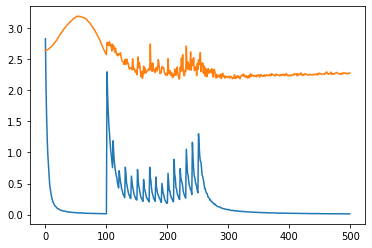

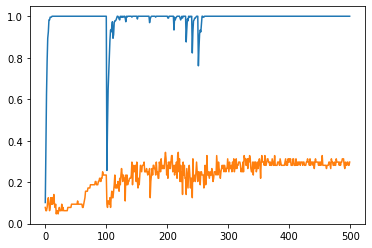

In [98]:
print(hist_p.history)
import matplotlib.pyplot as plt
plt.plot(hist_p.history["loss"])
plt.plot(hist_p.history["val_loss"])
plt.show()

plt.plot(hist_p.history["accuracy"])
plt.plot(hist_p.history["val_accuracy"])
plt.show()

{'loss': [2.8277809619903564, 2.0500166416168213, 1.5563673973083496, 1.2246882915496826, 0.9600787162780762, 0.7792167067527771, 0.598508894443512, 0.48421838879585266, 0.40808939933776855, 0.33944857120513916, 0.28316667675971985, 0.24336282908916473, 0.21202875673770905, 0.18740582466125488, 0.16797341406345367, 0.14847956597805023, 0.13781587779521942, 0.12678804993629456, 0.12020590156316757, 0.10366636514663696, 0.0952065959572792, 0.09234840422868729, 0.08719197660684586, 0.08366959542036057, 0.0765915960073471, 0.06990914046764374, 0.06788826733827591, 0.06379356980323792, 0.06282113492488861, 0.059471070766448975, 0.058786578476428986, 0.05788949131965637, 0.0536658875644207, 0.053079720586538315, 0.04855501651763916, 0.04671023041009903, 0.04341559112071991, 0.04412819817662239, 0.043681371957063675, 0.04139092564582825, 0.043306197971105576, 0.03834697604179382, 0.03684345632791519, 0.03689314052462578, 0.03556651249527931, 0.03465845808386803, 0.034067004919052124, 0.032480

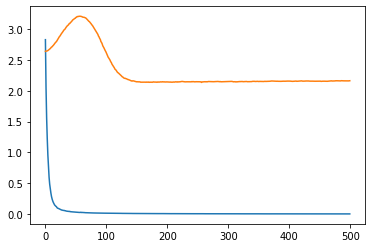

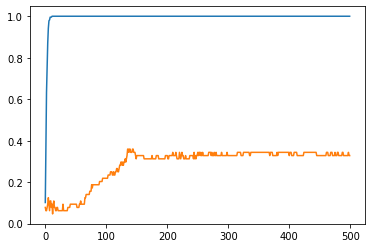

In [99]:
print(hist_s.history)
import matplotlib.pyplot as plt
plt.plot(hist_s.history["loss"])
plt.plot(hist_s.history["val_loss"])
plt.show()


plt.plot(hist_s.history["accuracy"])
plt.plot(hist_s.history["val_accuracy"])
plt.show()

In [100]:
simple_model_file = 'simple_model.h5'
tf.keras.models.save_model(model_simple, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_0.h5'
tf.keras.models.save_model(new_pruned_model_0, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_1.h5'
tf.keras.models.save_model(new_pruned_model_1, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_2.h5'
tf.keras.models.save_model(new_pruned_model_2, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_3.h5'
tf.keras.models.save_model(new_pruned_model_3, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_4.h5'
tf.keras.models.save_model(new_pruned_model_4, simple_model_file,
                        include_optimizer=False)




"""
This code saves the "model_simple" model to a file called "simple_model.h5"
using the TensorFlow's save_model function. The function takes two arguments, 
the first is the model to save and the second is the file name.
The include_optimizer=False argument is passed to the save_model function,
which means that the optimizer state will not be saved. This is useful when
we want to load the model and use a different optimizer or set of optimizer
hyperparameters.

The .h5 file format is a popular format for storing deep learning models.
It is supported by TensorFlow, Keras, and other deep learning libraries, 
and can be used to save the model's architecture, weights, and optimizer state.
This allows us to save the model and then reload it later to use for inference or transfer learning.

It is important to note that this will only save the architecture and
weights of the model, not the optimizer or other state. If you want to 
save the optimizer state as well, you can set include_optimizer=True, 
but it will increase the size of the file.

"""





In [101]:
model1=Model(model_simple.input, model_simple.output)
model1=model_simple.layers[2].output

#Quatisation

In [103]:
def quantModel(model, pathx):
  model_file="q_temp.h5"
  tf.keras.models.save_model(model, model_file,
                        include_optimizer=False)
  converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(model_file)

  converter.optimizations = [tf.compat.v1.lite.Optimize.OPTIMIZE_FOR_SIZE]

  tflite_quant_model = converter.convert()

  tflite_quant_model_file = pathx
  with open(tflite_quant_model_file, 'wb') as f:
    f.write(tflite_quant_model)


""""
This code defines a function called "quantModel" that takes in two arguments, 
"model" and "pathx". The function first saves the model to a file called
"q_temp.h5" using the save_model function as described before.


The function then creates an instance of the TensorFlow Lite (TFLite)
Converter by calling the "from_keras_model_file" function and passing
it the "q_temp.h5" file. The TFLite converter is used to convert the 
saved keras model to a TensorFlow Lite model file, which is a lightweight 
format for deploying models on mobile and embedded devices.

The code then sets the "optimizations" parameter of the converter 
to "tf.compat.v1.lite.Optimize.OPTIMIZE_FOR_SIZE". This optimization 
will reduce the size of the model by quantizing the model's weights
to 8-bit integers, which can significantly reduce the size of the 
model without significantly affecting its accuracy.

The function then calls the "convert()" function of the converter 
to convert the model to TensorFlow Lite format and saves the resulting 
TensorFlow Lite model to a file specified by the pathx argument.

This function can be used to convert the model to TensorFlow Lite
format, and then the resulting tflite file can be used to deploy
the model on mobile and embedded devices.

"""



def eval_model(lite_file, x_test, y_test):
  interpreter = tf.compat.v1.lite.Interpreter(model_path=str(lite_file))
  interpreter.allocate_tensors()
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  total_seen = 0
  num_correct = 0
  for img, label in zip(x_test, y_test):
    inp = img.reshape((1, 50, 50, 3))
    total_seen += 1
    interpreter.set_tensor(input_index, inp)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    if np.argmax(predictions) == np.argmax(label):
      num_correct += 1
  return float(num_correct) / float(total_seen)



"""
This code defines a function called "eval_model" that takes in three arguments:
"lite_file", "x_test", and "y_test".

The function first creates an instance of the TensorFlow Lite Interpreter
by passing it the path of the TensorFlow Lite model file (lite_file). 
The interpreter is used to execute the TensorFlow Lite model on a given input.

Then the function allocates the tensors and gets the indices of the input
and output tensors of the TensorFlow Lite model.

The function then runs a for loop over the "x_test" and "y_test" data, 
where it first reshapes the image to the expected input shape of the model.
It then sets the input tensor of the interpreter to the reshaped image and invokes the interpreter to get the predictions.

The function then compares the predicted label (argmax of predictions) 
with the true label (argmax of label) and increments the num_correct counter
if they match.

After all the images have been processed, the function calculates the 
accuracy by dividing the number of correctly classified images by the 
total number of images seen and returns the accuracy.

This function can be used to evaluate the performance of a TensorFlow 
Lite model on a given test dataset, it returns the accuracy of the model
on the test dataset.

"""


In [104]:
quantModel(model_simple, "lite_simple.tflite")
quantModel(new_pruned_model_0, "lite_0.tflite")
quantModel(new_pruned_model_1, "lite_1.tflite")
quantModel(new_pruned_model_2, "lite_2.tflite")
quantModel(new_pruned_model_3, "lite_3.tflite")

In [105]:
print(eval_model("lite_simple.tflite", X_test_50, y_test))
print(eval_model("lite_0.tflite", X_test_50, y_test))
print(eval_model("lite_1.tflite", X_test_50, y_test))
print(eval_model("lite_2.tflite", X_test_50, y_test))
print(eval_model("lite_3.tflite", X_test_50, y_test))

0.359375
0.28125
0.171875
0.25
0.109375


# FLOPS

In [106]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras.backend as K
import numpy as np
def get_flops(model):
  model_file="for_flops.h5"
  tf.keras.models.save_model(model, model_file,
                        include_optimizer=False)
  run_meta = tf.compat.v1.RunMetadata()
  with tf.compat.v1.Session(graph=tf.Graph()) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    net = load_model(model_file)
    x=np.ones([50,50,3])
    x_placeholder =  tf.compat.v1.placeholder(tf.float32, shape=(None,50,50,3))
    y = net(x_placeholder)


    #opts = tf.profiler.ProfileOptionBuilder.float_operation()
    opts=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation() 
    flops = tf.compat.v1.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.compat.v1.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops, params.total_parameters
  
  
  
  
  """
  This code defines a function called "get_flops" that takes in one argument 
  "model". The function first saves the model to a file called "for_flops.h5"
  using the save_model function as described before.

The function then creates a new TensorFlow session and sets the Keras 
backend session to that session. It then loads the saved model using the
load_model function.

The function creates a placeholder for the input tensor, and runs the
model on this placeholder with an input of shape (50,50,3) to get the output tensor.

The function then uses the TensorFlow profiler to profile the computation
graph and get the number of FLOPs (floating point operations) and the
number of parameters of the model.

The profiler is used to measure the total number of floating point 
operations required to execute the model on a given input. The number
of FLOPs is stored in the variable "flops.total_float_ops"

The profiler is also used to measure the total number of trainable 
parameters in the model. The number of parameters is stored in the
variable "params.total_parameters"

The function then returns the number of FLOPs and parameters of the model.

This function can be used to get the number of FLOPs and the
number of parameters of a given model, which can be used to
measure the computational cost
  
  """

In [108]:
s=get_flops(model_simple)
p0=get_flops(new_pruned_model_0)
p1=get_flops(new_pruned_model_1)
p2=get_flops(new_pruned_model_2)
p3=get_flops(new_pruned_model_3)
p4=get_flops(new_pruned_model_4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


In [109]:
print(s)
print(p0)
print(p1)
print(p2)
print(p3)
print(p4)

(758485, 755278)
(49149, 48362)
(32901, 32264)
(19047, 18570)
(9054, 8737)
(2634, 2477)


In [110]:
def printsize(f_model):
  print("Size of the model: %.2f Mb" 
      % (os.path.getsize(f_model) / float(2**20)))

printsize("simple_model.h5")
printsize("pruned_0.h5")
printsize("pruned_1.h5")
printsize("pruned_2.h5")
printsize("pruned_3.h5")
printsize("pruned_4.h5")

Size of the model: 2.93 Mb
Size of the model: 0.23 Mb
Size of the model: 0.17 Mb
Size of the model: 0.12 Mb
Size of the model: 0.08 Mb
Size of the model: 0.06 Mb


In [111]:
def printsize(f_model):
  print("Size of the model: %.2f Mb" 
      % (os.path.getsize(f_model) / float(2**20)))

printsize("lite_simple.tflite")
printsize("lite_0.tflite")
printsize("lite_1.tflite")
printsize("lite_2.tflite")
printsize("lite_3.tflite")

Size of the model: 0.74 Mb
Size of the model: 0.06 Mb
Size of the model: 0.04 Mb
Size of the model: 0.03 Mb
Size of the model: 0.02 Mb
